In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
df = pd.read_csv("spam.csv", encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [6]:
df = df.iloc[:, :2]
df.columns = ['label', 'message']

In [7]:
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [8]:
df['label'] = df['label'].map({'ham': 0, 'spam': 1}) # labels to binary

In [9]:
df.isnull().sum()

label      0
message    0
dtype: int64

In [10]:
df.shape

(5572, 2)

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
x = df['message']
y = df['label']

# converting text to numerical 
vectorizer = TfidfVectorizer(stop_words='english', lowercase=True)
x_vectorized = vectorizer.fit_transform(x)

In [12]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(x_vectorized, y, test_size=0.2, random_state=42)

In [13]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

In [14]:
from sklearn.metrics import accuracy_score
nb_model = MultinomialNB()
nb_model.fit(xtrain, ytrain)
nb_preds = nb_model.predict(xtest)
print("Naive Bayes Accuracy:", accuracy_score(ytest, nb_preds))

lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(xtrain, ytrain)
lr_preds = lr_model.predict(xtest)
print("Logistic Regression Accuracy:", accuracy_score(ytest, lr_preds))

Naive Bayes Accuracy: 0.968609865470852
Logistic Regression Accuracy: 0.9443946188340807


In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [16]:
# converting sparse TF-IDF matrices to dense (only needed for TensorFlow)
xtrain_dense = xtrain.toarray()
xtest_dense = xtest.toarray()

# Build NN
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(xtrain_dense.shape[1],)))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))  # Binary classification

# Compile
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train
model.fit(xtrain_dense, ytrain, epochs=5, batch_size=32, validation_data=(xtest_dense, ytest), verbose=2)

# Evaluate
loss, accuracy = model.evaluate(xtest_dense, ytest, verbose=0)
print("Neural Network Accuracy:", accuracy)


C:\Python 3.11\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
140/140 - 4s - 29ms/step - accuracy: 0.8831 - loss: 0.3039 - val_accuracy: 0.9659 - val_loss: 0.1348
Epoch 2/5
140/140 - 2s - 13ms/step - accuracy: 0.9879 - loss: 0.0519 - val_accuracy: 0.9803 - val_loss: 0.0697
Epoch 3/5
140/140 - 2s - 13ms/step - accuracy: 0.9978 - loss: 0.0102 - val_accuracy: 0.9785 - val_loss: 0.0759
Epoch 4/5
140/140 - 2s - 13ms/step - accuracy: 0.9993 - loss: 0.0047 - val_accuracy: 0.9803 - val_loss: 0.0800
Epoch 5/5
140/140 - 2s - 12ms/step - accuracy: 0.9993 - loss: 0.0026 - val_accuracy: 0.9812 - val_loss: 0.0811
Neural Network Accuracy: 0.9811659455299377


In [24]:
import pickle
with open("tfidf.pkl", "wb") as f:
    pickle.dump(vectorizer, f)

In [25]:
model.save("spam_model.h5")

In [26]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
# Predict on test set
y_pred_nn = (model.predict(xtest_dense) > 0.5).astype("int32").flatten()

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


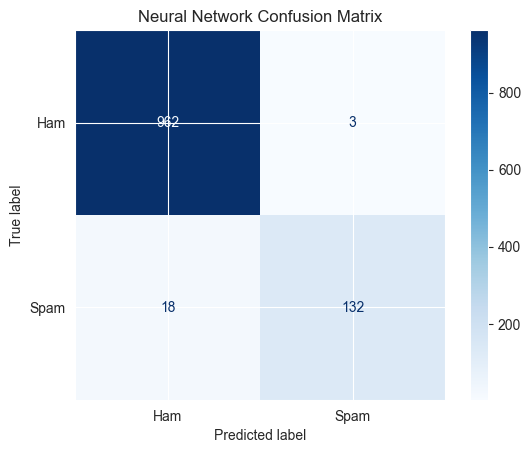

              precision    recall  f1-score   support

         Ham       0.98      1.00      0.99       965
        Spam       0.98      0.88      0.93       150

    accuracy                           0.98      1115
   macro avg       0.98      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115



In [27]:
cm = confusion_matrix(ytest, y_pred_nn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Ham', 'Spam'])
disp.plot(cmap='Blues')
plt.title("Neural Network Confusion Matrix")
plt.show()

# Classification report
print(classification_report(ytest, y_pred_nn, target_names=["Ham", "Spam"]))

In [29]:
model = tf.keras.models.load_model("spam_model.h5")

with open("tfidf.pkl", "rb") as f:
    tfidf = pickle.load(f)

# Define the function
def predict_message(message):
    message_tfidf = tfidf.transform([message]).toarray()
    prediction = model.predict(message_tfidf)[0][0]

    print(f"\n📨 Input Message: {message}")
    if prediction > 0.5:
        print(f"📩 Prediction: **SPAM** (Confidence: {prediction:.2f})")
    else:
        print(f"✅ Prediction: **NOT SPAM** (Confidence: {1 - prediction:.2f})")

# Example predictions
predict_message("Congratulations! You've won a free iPhone. Click here to claim.")
predict_message("Hi, can we meet at 5 PM for our project discussion?")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step

📨 Input Message: Congratulations! You've won a free iPhone. Click here to claim.
📩 Prediction: **SPAM** (Confidence: 1.00)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step

📨 Input Message: Hi, can we meet at 5 PM for our project discussion?
✅ Prediction: **NOT SPAM** (Confidence: 1.00)
